In [1]:
import numpy as np
import pandas as pd
import datetime, json
import keras
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Lambda, Concatenate, Dropout, BatchNormalization, Dot, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate, add, multiply, dot, maximum
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import confusion_matrix, f1_score
%matplotlib inline

Using TensorFlow backend.


In [2]:
MAX_SEQ_LENGTH = 25
L2 = 1e-5
DROUPOUT_PROB = 0.1
Q1_TRAINING_DATA_FILE = 'q1_train_{0}.npy'
Q2_TRAINING_DATA_FILE = 'q2_train_{0}.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
VALIDATION_SPLIT = 0.1
EMBEDDING_DIM = 300
TEST_SPLIT = 0.1
RNG_SEED = 102203
NB_EPOCHS = 25
BATCH_SIZE = 32

In [3]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE,'rb'))
word_embedding = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']
    
#partition data into train/val set


In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def calc_distance(vects):
    x, y = vects
    return K.sum(K.square(x - y), axis=1, keepdims=True)

def get_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

lstm_layer = LSTM(100, recurrent_dropout=0.2)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 50, 300)      23541600    input_33[0][0]                   
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 50, 300)      23541600    input_34[0][0]                   
__________________________________________________________________________________________________
lstm_21 (L

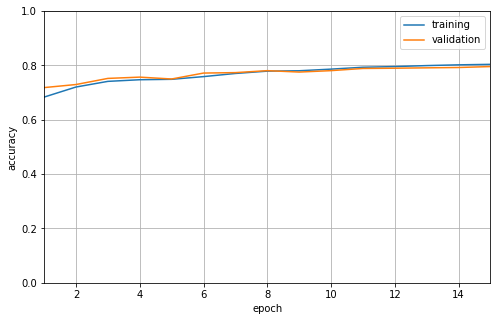

In [35]:
# distance based model
seq_len = [50]#,100]

for sq in seq_len:
    
    # read input based on the sequence length
    q1data = np.load(open(Q1_TRAINING_DATA_FILE.format(sq), 'rb'))
    q2data = np.load(open(Q2_TRAINING_DATA_FILE.format(sq), 'rb'))
    X = np.stack((q1data, q2data), axis=1)
    y = labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SPLIT, random_state=RNG_SEED)
    Q1_train = X_train[:,0]
    Q2_train = X_train[:,1]
    Q1_test = X_test[:,0]
    Q2_test = X_test[:,1]

    # build network
    input_q1 = Input(shape=(sq,), dtype='int32')
    input_q2 = Input(shape=(sq,), dtype='int32')

    q1 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q1)

    q2 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q2)

    q1 = lstm_layer(q1)
    q2 = lstm_layer(q2)

    dist_q1q2 = Lambda(calc_distance, output_shape= get_output_shape)([q1,q2])

    for i in range(3):
        dist_q1q2 = Dense(200, activation= 'tanh',
                          kernel_initializer='glorot_uniform',
                          bias_initializer='zeros',
                          kernel_regularizer=l2(L2) if L2 else None)(dist_q1q2)
        dist_q1q2 = Dropout(DROUPOUT_PROB)(dist_q1q2)
        dist_q1q2 = BatchNormalization()(dist_q1q2)

    pred = Dense(1, activation='sigmoid')(dist_q1q2)

    model = Model(inputs=[input_q1,input_q2], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    print(model.summary())
    
    t0 = time()
    
    callbacks = [ModelCheckpoint('distance_model_25.h5', monitor='val_acc', save_best_only=True)]
    train_states = model.fit([Q1_train, Q2_train],
                                y_train,
                                epochs = 15,# NB_EPOCHS,
                                validation_split=VALIDATION_SPLIT,
                                verbose=2,
                                batch_size=BATCH_SIZE,
                                callbacks=callbacks)
    t1 = time()
    print('Minutes elapsed: %f' % ((t1-t0)/60.0))

    loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
    yhat =  model.predict([Q1_test, Q2_test])
    rounded = [round(x[0]) for x in yhat]
    f1s = f1_score(y_test,rounded,average='weighted')
    
    print('loss = {0:.4f}, accuracy = {1:.4f}, f1-score = {1:.4f}'.format(loss, accuracy,f1s ))
    
    #plot training and validation accuracy
    acc = pd.DataFrame({'epoch': [ i + 1 for i in train_states.epoch ],
                        'training': train_states.history['acc'],
                        'validation': train_states.history['val_acc']})
    ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
    ax.set_ylabel("accuracy")
    ax.set_ylim([0.0,1.0])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 50, 300)      23541600    input_35[0][0]                   
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 50, 300)      23541600    input_36[0][0]                   
__________________________________________________________________________________________________
lstm_22 (L

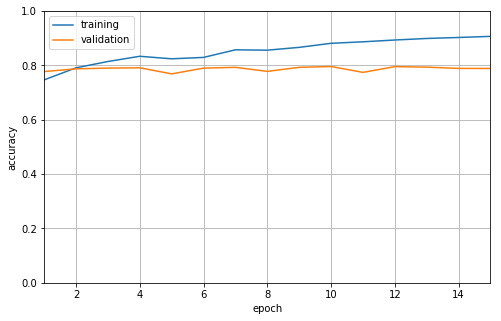

In [36]:
#LSTM with attention
seq_len = [50] #,100]

for sq in seq_len:
    
    # read input based on the sequence length
    q1data = np.load(open(Q1_TRAINING_DATA_FILE.format(sq), 'rb'))
    q2data = np.load(open(Q2_TRAINING_DATA_FILE.format(sq), 'rb'))
    X = np.stack((q1data, q2data), axis=1)
    y = labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SPLIT, random_state=RNG_SEED)
    Q1_train = X_train[:,0]
    Q2_train = X_train[:,1]
    Q1_test = X_test[:,0]
    Q2_test = X_test[:,1]

    # build network
    input_q1 = Input(shape=(sq,), dtype='int32')
    input_q2 = Input(shape=(sq,), dtype='int32')

    q1 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q1)

    q2 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q2)

    q1 = LSTM(100, recurrent_dropout=0.2)(q1)
    q2 = LSTM(100, recurrent_dropout=0.2)(q2)
    
    dist_q1q2 = maximum([q1,q2])

    for i in range(1):
        dist_q1q2 = Dense(200, activation= 'tanh',
                          kernel_initializer='glorot_uniform',
                          bias_initializer='zeros',
                          kernel_regularizer=l2(L2) if L2 else None)(dist_q1q2)
        dist_q1q2 = Dropout(DROUPOUT_PROB)(dist_q1q2)
        dist_q1q2 = BatchNormalization()(dist_q1q2)

    pred = Dense(1, activation='sigmoid')(dist_q1q2)

    model = Model(inputs=[input_q1,input_q2], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    print(model.summary())
    
    t0 = time()
    
    callbacks = [ModelCheckpoint('lstm_bow_50.h5', monitor='val_acc', save_best_only=True)]
    train_states = model.fit([Q1_train, Q2_train],
                                y_train,
                                epochs = 15,# NB_EPOCHS,
                                validation_split=VALIDATION_SPLIT,
                                verbose=2,
                                batch_size=BATCH_SIZE,
                                callbacks=callbacks)
    t1 = time()
    print('Minutes elapsed: %f' % ((t1-t0)/60.0))

    loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
    yhat =  model.predict([Q1_test, Q2_test])
    rounded = [round(x[0]) for x in yhat]
    f1s = f1_score(y_test,rounded,average='weighted')
    
    print('loss = {0:.4f}, accuracy = {1:.4f}, f1-score = {1:.4f}'.format(loss, accuracy,f1s ))
    #plot training and validation accuracy
    acc = pd.DataFrame({'epoch': [ i + 1 for i in train_states.epoch ],
                        'training': train_states.history['acc'],
                        'validation': train_states.history['val_acc']})
    ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
    ax.set_ylabel("accuracy")
    ax.set_ylim([0.0,1.0])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 50, 300)      23541600    input_37[0][0]                   
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 50, 300)      23541600    input_38[0][0]                   
__________________________________________________________________________________________________
time_distr

(0.0, 1.0)

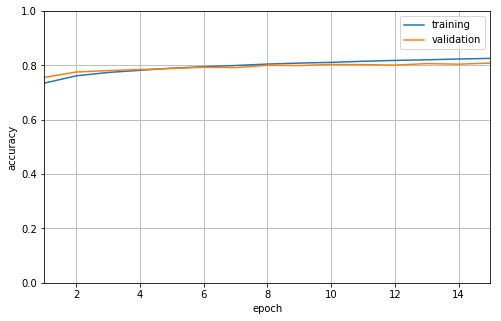

In [37]:
sq = 50
q1data = np.load(open(Q1_TRAINING_DATA_FILE.format(sq), 'rb'))
q2data = np.load(open(Q2_TRAINING_DATA_FILE.format(sq), 'rb'))
    
#partition data into train/val set
X = np.stack((q1data, q2data), axis=1)
y = labels
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

input_q1 = Input(shape=(sq,), dtype='int32')
input_q2 = Input(shape=(sq,), dtype='int32')
    
q1 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q1)
    
q2 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q2)
    
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
    
SumEmbeddings = Lambda(lambda x: K.sum(x, axis=1), output_shape=(EMBEDDING_DIM,))
    
q1 = SumEmbeddings(q1)
q2 = SumEmbeddings(q2)
    
q1 = BatchNormalization()(q1)
q2 = BatchNormalization()(q2)
    
combined = concatenate([q1,q2])
combined = Dropout(0.1)(combined)
    
for i in range(3):
        #2 * EMBEDDING_DIM
    combined = Dense(300, activation= 'relu', kernel_regularizer=l2(L2) if L2 else None)(combined)
    combined = Dropout(0.1)(combined)
    combined = BatchNormalization()(combined)
        
pred = Dense(1, activation='sigmoid')(combined)
    
model = Model(inputs=[input_q1,input_q2], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
print(model.summary())
t0 = time()
    
callbacks = [ModelCheckpoint('bow_model_sum.h5', monitor='val_acc', save_best_only=True)]
train_states = model.fit([Q1_train, Q2_train],
                            y_train,
                            epochs = 15,#NB_EPOCHS,
                            validation_split=VALIDATION_SPLIT,
                            verbose=2,
                            batch_size=BATCH_SIZE,
                            callbacks=callbacks)
t1 = time()
print('Minutes elapsed: %f' % ((t1-t0)/60.0))
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
yhat =  model.predict([Q1_test, Q2_test])
rounded = [round(x[0]) for x in yhat]
f1s = f1_score(y_test,rounded,average='weighted')
    
print('loss = {0:.4f}, accuracy = {1:.4f}, f1-score = {1:.4f}'.format(loss, accuracy,f1s ))

#plot training and validation accuracy
acc = pd.DataFrame({'epoch': [ i + 1 for i in train_states.epoch ],
                    'training': train_states.history['acc'],
                    'validation': train_states.history['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0])
    

loss = 0.4396, accuracy = 0.7933, f1-score = 0.7933
Normalized confusion matrix
             precision    recall  f1-score   support

          0       0.86      0.81      0.83     25529
          1       0.70      0.77      0.73     14900

avg / total       0.80      0.79      0.80     40429



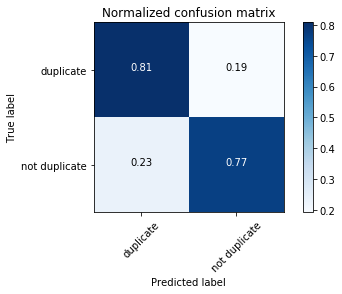

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

sq = 50
q1data = np.load(open(Q1_TRAINING_DATA_FILE.format(sq), 'rb'))
q2data = np.load(open(Q2_TRAINING_DATA_FILE.format(sq), 'rb'))
    
#partition data into train/val set
X = np.stack((q1data, q2data), axis=1)
y = labels
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

input_q1 = Input(shape=(sq,), dtype='int32')
input_q2 = Input(shape=(sq,), dtype='int32')

q1 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q1)

q2 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=sq,
                  trainable=False)(input_q2)

q1 = lstm_layer(q1)
q2 = lstm_layer(q2)

dist_q1q2 = Lambda(calc_distance, output_shape= get_output_shape)([q1,q2])

for i in range(3):
    dist_q1q2 = Dense(200, activation= 'tanh',
                          kernel_initializer='glorot_uniform',
                          bias_initializer='zeros',
                          kernel_regularizer=l2(L2) if L2 else None)(dist_q1q2)
    dist_q1q2 = Dropout(DROUPOUT_PROB)(dist_q1q2)
    dist_q1q2 = BatchNormalization()(dist_q1q2)

pred = Dense(1, activation='sigmoid')(dist_q1q2)

model = Model(inputs=[input_q1,input_q2], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


model.load_weights('distance_model_25.h5')
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
yhat =  model.predict([Q1_test, Q2_test])
rounded_1 = [1 if x[0] >= 0.5 else 0 for x in yhat]

f1s = f1_score(y_test,rounded_1,average='weighted')
    
print('loss = {0:.4f}, accuracy = {1:.4f}, f1-score = {1:.4f}'.format(loss, accuracy,f1s ))


cnf_matrix = confusion_matrix(y_test, rounded_1)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['duplicate','not duplicate'], normalize=True,
                      title='Normalized confusion matrix')

print (classification_report(y_test,rounded_1 ))

In [25]:


input_f1 = Input(shape=(X_train_feat.shape[1],), dtype='float32')

f1 = BatchNormalization()(input_f1)

for i in range(3):
    f1 = Dense(300, activation='relu')(f1)
    f1 = Dropout(0.2)(f1)
    f1 = BatchNormalization()(f1)
    
pred = Dense(1, activation='sigmoid')(f1)

model = Model(inputs=[input_f1], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 35)                0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 35)                140       
_________________________________________________________________
dense_33 (Dense)             (None, 300)               10800     
_________________________________________________________________
dropout_25 (Dropout)         (None, 300)               0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 300)               1200      
_________________________________________________________________
dense_34 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_26 (Dropout)         (None, 300)               0         
__________